<a href="https://colab.research.google.com/github/uldkh/colab_projects/blob/main/kaggle_MegaFon_Accelerator_top1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from collections import Counter, defaultdict
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
train = pd.read_csv("/content/contest_train.csv")
test = pd.read_csv("/content/contest_test.csv")

In [ ]:
test.isna().sum().sort_values(ascending=False)[:20]

FEATURE_189    9274
FEATURE_190    6201
FEATURE_194    5727
FEATURE_191    5658
FEATURE_192    4925
FEATURE_193    4695
FEATURE_187    4386
FEATURE_151     852
FEATURE_152     852
FEATURE_153     852
FEATURE_150     852
FEATURE_149     852
FEATURE_8       657
FEATURE_71      532
FEATURE_73      532
FEATURE_72      484
FEATURE_195     484
FEATURE_188     416
FEATURE_162     303
FEATURE_256     273
dtype: int64

In [ ]:
train.isna().sum().sort_values(ascending=False)[:20]

FEATURE_189    24196
FEATURE_194    17245
FEATURE_190    17192
FEATURE_191    15309
FEATURE_192    13060
FEATURE_193    12596
FEATURE_187    11878
FEATURE_73      2960
FEATURE_71      2960
FEATURE_195     2787
FEATURE_72      2781
FEATURE_153     2418
FEATURE_149     2418
FEATURE_150     2418
FEATURE_151     2418
FEATURE_152     2418
FEATURE_8       1144
FEATURE_188     1064
FEATURE_162      632
FEATURE_196      467
dtype: int64

In [ ]:
train.nunique().sort_values(ascending=True)

FEATURE_249        1
FEATURE_3          1
FEATURE_256        1
FEATURE_144        1
FEATURE_19         2
               ...  
FEATURE_93     24521
FEATURE_94     24521
FEATURE_95     24521
FEATURE_65     24521
ID             24521
Length: 262, dtype: int64

In [ ]:
test_id = test["ID"]
train.drop("ID", axis=1, inplace=True)
test.drop("ID", axis=1, inplace=True)
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)

In [ ]:
labels = train.pop("TARGET")
print(train.shape, test.shape)

(24521, 260) (9484, 260)


In [ ]:
labels.value_counts(normalize=True)

0    0.708454
1    0.230415
2    0.061131
Name: TARGET, dtype: float64

In [ ]:
constant_features = [feature for feature in train.columns if train[feature].nunique() == 1]
constant_features

['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256']

In [ ]:
train.drop(labels=constant_features, axis=1, inplace=True)
test.drop(labels=constant_features, axis=1, inplace=True)

In [ ]:
def remove_corr_feat(df, corr):

    corr_counter = Counter()
    dict_corr = defaultdict(list)
    corr_mx = df.corr() 
    
    for col in df.columns:

        hi_cor_list = list(
            corr_mx[col][(abs(corr_mx[col]) > corr) & 
                         (abs(corr_mx[col]) < 1)].index)
        dict_corr[col] = hi_cor_list
        for feat in hi_cor_list:
            corr_counter[feat] += 1
            
    corr_counter = {k: v for k, v in sorted(
        corr_counter.items(),
        key=lambda item: item[1],
        reverse=True)}

    for feature in corr_counter.keys():
        for item in dict_corr[feature]:

    dict_corr = {k: v for k, v in dict_corr.items() if len(v) > 0}
    
        if feat in dict_corr.keys():
            df = df.drop(dict_corr[feat], axis=1, errors='ignore')                                       
    return df

In [ ]:
corrs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res_f1 = [

cv_strategy = RepeatedStratifiedKFold(
    n_splits=3, n_repeats=3, random_state=42)    

for corr in corrs:
    train_reduced = remove_corr_feat(train, corr)
    selector = CatBoostClassifier(
        iterations=200,
        loss_function='MultiClass',
        random_seed=42,
        random_strength=0.15,
        depth=9,                                  
        learning_rate=0.1,
        auto_class_weights='Balanced',
        logging_level='Silent') 
    cvs = cross_val_score(
        selector, train_reduced, labels, 
        cv=cv_strategy, 
        scoring='f1_macro').mean()
    print(f'параметр: {corr}, '
          f'кол-во переменных: {train_reduced.shape[1]}, '
          f'F1: {np.round(cvs, 5)}')
    res_f1.append(np.round(cvs, 5))

In [ ]:
train = remove_corr_feat(train, 0.5)

In [ ]:
categorical_features = (train.nunique()[train.nunique()==2]).index

In [ ]:
categorical_features_df = train[categorical_features]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.3, stratify=labels, random_state=42)

In [ ]:
X_train_cat_df = X_train[categorical_features]

In [ ]:
X_train.drop(categorical_features, axis=1, inplace=True)

#pca test

In [ ]:
kmo_all, kmo_model = calculate_kmo(X_train)
print("Global KMO = ", kmo_model)

Global KMO =  0.8701273983006615


/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [ ]:
kmo_for_features = pd.DataFrame(data=kmo_all, index=train.columns, columns=["kmo"])
kmo_for_features.sort_values(by="kmo", ascending=False).head(10)

,kmo
FEATURE_127,0.997717
FEATURE_135,0.994914
FEATURE_197,0.990650
FEATURE_185,0.988439
FEATURE_244,0.986794
FEATURE_237,0.986522
FEATURE_177,0.986361
FEATURE_7,0.986261
FEATURE_240,0.986163
FEATURE_181,0.983636


In [ ]:
columns_for_pca = kmo_for_features[kmo_for_features.kmo > 0.55].index
columns_for_pca.shape

(228,)

In [ ]:
data_for_pca = StandardScaler().fit_transform(X_train)

In [ ]:
pca =  PCA(n_components=data_for_pca.shape[1], random_state=42).fit(data_for_pca)

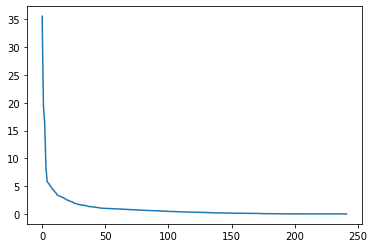

In [ ]:
plt.plot(pca.explained_variance_ratio_ * data_for_pca.shape[1])

In [ ]:
((pca.explained_variance_ratio_ * data_for_pca.shape[1]) > 0.8).sum()

67

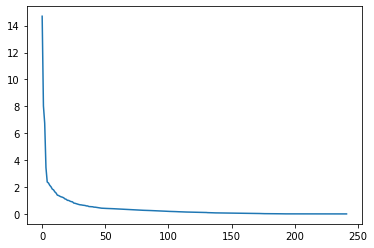

In [ ]:
plt.plot(pca.explained_variance_ratio_ * 100)

In [ ]:
pca = PCA(50, random_state=42).fit(data_for_pca)
pca.transform(data_for_pca)

array([[ 6.65815102e+00,  7.78011414e-03,  1.28384245e+00, ...,
        -1.37277823e-01, -2.76013353e-01,  1.35613531e+00],
       [-2.18344733e+00, -2.91201649e+00,  1.04098654e+00, ...,
         8.33423740e-01, -4.75665291e-01,  7.63615750e-01],
       [ 1.06197459e+00, -2.30872400e+00,  1.59739888e+00, ...,
        -4.74904566e+00, -5.62782715e-01,  3.51741977e+00],
       ...,
       [-9.21373410e+00,  1.16785767e+00, -1.61170172e+00, ...,
        -1.97418521e-01, -3.00325944e-01, -3.95447288e-01],
       [-1.12170267e+00,  1.74772161e+00, -2.42092497e+00, ...,
        -3.43970135e-01,  7.71154292e-02, -1.78662759e+00],
       [-1.27322558e+00, -2.18866516e+00,  1.28492263e+00, ...,
        -1.10172669e+00, -1.39144504e+00, -3.99436445e-03]])

In [ ]:
new_features = PCA(61, random_state=42).fit_transform(data_for_pca)

In [ ]:
new_features = pd.DataFrame(new_features, columns=["f_" + str(i) for i in range(new_features.shape[1])])

In [ ]:
new_features = new_features.merge(categorical_features_df, how="outer", left_index=True, right_index=True)

In [ ]:
%%time
for n in range(50, 80, 1):
  data_for_pca = StandardScaler().fit_transform(train)
  new_features = PCA(n, random_state=42).fit_transform(data_for_pca)
  new_features = pd.DataFrame(new_features, columns=["f_" + str(i) for i in range(new_features.shape[1])])
  new_features = new_features.merge(categorical_features_df, how="outer", left_index=True, right_index=True)

  cv_strategy = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
  selector = CatBoostClassifier(learning_rate=0.1,
                            loss_function='MultiClass',
                            depth=3,
                            rsm=1,
                            iterations=200,
                            random_strength=0.15,
                            random_seed=42,
                            auto_class_weights='Balanced',
                            logging_level="Silent",
                            task_type="GPU"
                            )
  cvs = cross_val_score(selector, new_features, labels, cv=cv_strategy, scoring="f1_macro").mean()

  print(f"pc_components: {n}, F1: {np.round(cvs, 5)}")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

pc_components: 50, F1: 0.45527
pc_components: 51, F1: 0.45774
pc_components: 52, F1: 0.45788
pc_components: 53, F1: 0.45806
pc_components: 54, F1: 0.45872
pc_components: 55, F1: 0.45729
pc_components: 56, F1: 0.45693
pc_components: 57, F1: 0.45929
pc_components: 58, F1: 0.45859
pc_components: 59, F1: 0.45847
pc_components: 60, F1: 0.45938
pc_components: 61, F1: 0.46088
pc_components: 62, F1: 0.4596
pc_components: 63, F1: 0.45873
pc_components: 64, F1: 0.45887
pc_components: 65, F1: 0.45944
pc_components: 66, F1: 0.45992
pc_components: 67, F1: 0.45886
pc_components: 68, F1: 0.45827
pc_components: 69, F1: 0.45994
pc_components: 70, F1: 0.45896
pc_components: 71, F1: 0.4597
pc_components: 72, F1: 0.45936
pc_components: 73, F1: 0.45905
pc_components: 74, F1: 0.45964
pc_components: 75, F1: 0.45873
pc_components: 76, F1: 0.45972
pc_components: 77, F1: 0.45695
pc_components: 78, F1: 0.45895
pc_components: 79, F1: 0.45861
CPU times: user 6min 43s, sys: 5min 8s, total: 11min 51s
Wall time: 7min

In [ ]:
for n in range(50, 80, 1):
  data_for_pca = StandardScaler().fit_transform(X_train)
  new_features = PCA(n, random_state=42).fit_transform(data_for_pca)
  new_features = pd.DataFrame(new_features, columns=["f_" + str(i) for i in range(new_features.shape[1])])
  new_features = new_features.merge(X_train_cat_df.reset_index(drop=True), how="outer", left_index=True, right_index=True)

  cv_strategy = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
  selector = CatBoostClassifier(learning_rate=0.1,
                            loss_function='MultiClass',
                            depth=9,
                            rsm=1,
                            iterations=200,
                            random_strength=0.15,
                            random_seed=42,
                            auto_class_weights='Balanced',
                            logging_level="Silent",
                            task_type="GPU"
                            )
  cvs = cross_val_score(selector, new_features, y_train, cv=cv_strategy, scoring="f1_macro").mean()

  print(f"pc_components: {n}, F1: {np.round(cvs, 5)}")

In [ ]:
for n in range(58, 59, 1):
  data_for_pca = StandardScaler().fit_transform(X_train)
  new_features = PCA(n, random_state=42).fit_transform(data_for_pca)
  new_features = pd.DataFrame(new_features, columns=["f_" + str(i) for i in range(new_features.shape[1])])
  new_features = new_features.merge(X_train_cat_df.reset_index(drop=True), how="outer", left_index=True, right_index=True)

  cv_strategy = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
  selector = CatBoostClassifier(learning_rate=0.1,
                            loss_function='MultiClass',
                            depth=9,
                            rsm=1,
                            iterations=200,
                            random_strength=0.15,
                            random_seed=42,
                            auto_class_weights='Balanced',
                            logging_level="Silent",
                            task_type="GPU"
                            )
  cvs = cross_val_score(selector, new_features, y_train, cv=cv_strategy, scoring="f1_macro").mean()

  print(f"pc_components: {n}, F1: {np.round(cvs, 5)}")

pc_components: 58, F1: 0.49063


In [ ]:
output = cross_validate(
    selector,
    new_features, 
    y_train, 
    cv=cv_strategy, 
    scoring='f1_macro', 
    return_estimator=True)

In [ ]:
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx) for idx in range(len(fi))],
    index=new_features.columns)

fi.head()

,importance 0,importance 1,importance 2,importance 3,importance 4,importance 5,importance 6,importance 7,importance 8
f_0,9.462772,9.158198,8.500605,9.983011,9.814444,9.151843,9.165909,9.643101,9.573613
f_1,2.784460,3.311807,3.316787,3.631290,3.967297,2.830783,3.362953,3.179135,2.774116
f_2,1.564602,1.329012,1.601125,1.074012,0.759030,1.254041,1.365185,1.149391,0.884082
f_3,1.356647,0.845981,1.606981,1.207115,0.798897,1.371558,1.171317,0.773028,1.521326
f_4,0.878860,1.051733,0.939397,0.997789,1.482601,0.933962,1.015232,1.247018,0.789336


In [ ]:
fi["mean_importance"] = fi.mean(axis=1)
fi.mean_importance.sort_values(ascending=False)[categorical_features]

FEATURE_2      0.001417
FEATURE_4      0.017536
FEATURE_5      0.000006
FEATURE_6      0.000000
FEATURE_11     0.003950
FEATURE_15     0.022389
FEATURE_16     0.035722
FEATURE_17     0.021389
FEATURE_18     0.025553
FEATURE_19     0.006144
FEATURE_140    0.000000
FEATURE_159    0.000000
FEATURE_254    2.795251
FEATURE_255    1.818401
Name: mean_importance, dtype: float64

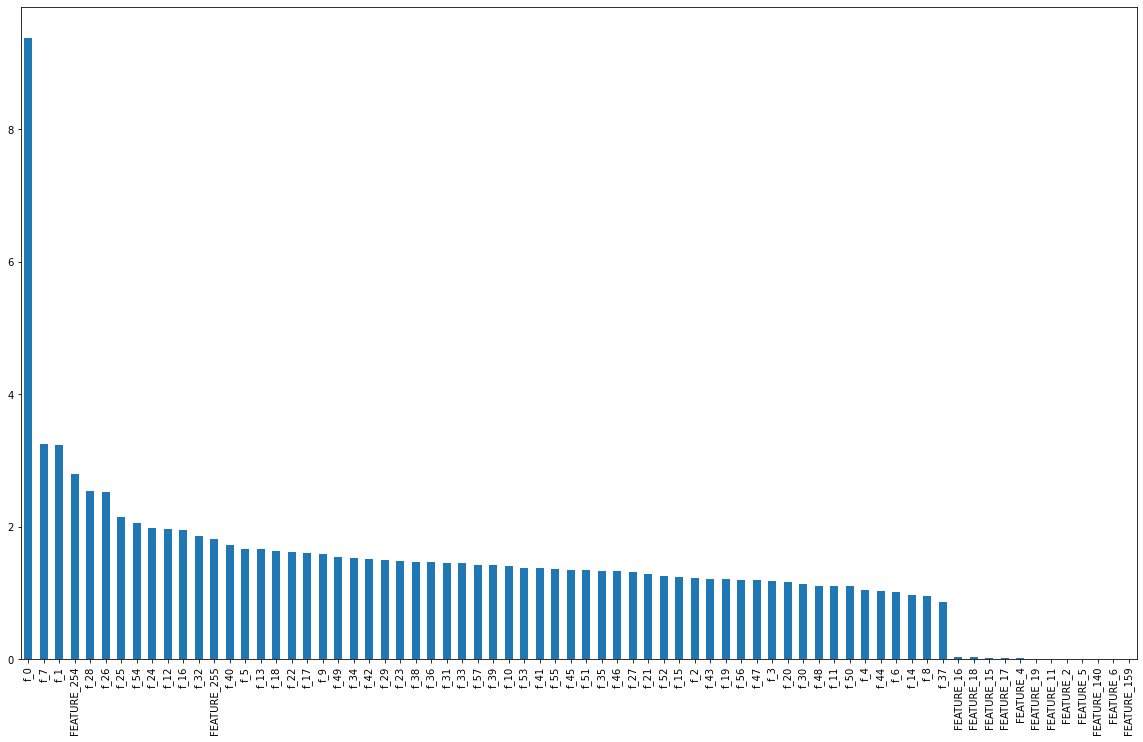

In [ ]:
fi.mean_importance.sort_values(ascending=False).plot.bar(figsize=(20, 12))
plt.show()

In [ ]:
score_all = output["test_score"].mean()

In [ ]:
score_all

0.4906312955216417

In [ ]:
features_imp = fi.mean_importance.sort_values(ascending=False).copy()

In [ ]:
features = list(fi.mean_importance.sort_values(ascending=False).index)

In [ ]:
new_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_11,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_140,FEATURE_159,FEATURE_254,FEATURE_255
0,6.658151,0.007778,1.283841,1.587501,1.267051,-0.451213,2.553182,3.730834,-1.216276,2.198007,-0.903316,-2.598987,-1.369421,-2.504058,-0.778453,-0.245775,-3.352905,1.631577,0.556420,1.131754,-0.835167,-0.300279,0.926251,0.282864,0.251313,0.024962,1.207062,0.954286,-0.108299,-3.615642,0.624456,-0.839259,0.823349,2.762855,-0.832002,0.632244,-0.075290,1.901255,-2.197905,0.296446,-0.658800,-0.507457,0.045197,-0.178627,0.686825,0.002680,0.337244,-0.093964,0.887661,-1.045207,-0.179248,0.455148,-0.683572,-0.889901,-0.257458,-0.015643,-0.415152,-0.331228,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-2.183447,-2.912017,1.040986,-3.352631,-0.523052,-0.309001,1.055682,-0.335804,1.534117,-3.494709,0.981679,-0.071174,-1.859720,2.965252,0.254882,-0.345740,0.107289,1.800494,0.817824,1.155920,1.038627,-1.675893,-0.266203,0.537183,0.808020,-0.587696,0.036309,-0.741549,-0.150896,-0.252379,-0.402569,-0.328081,0.460812,-0.971585,-0.594649,0.675745,-0.053772,-0.073184,0.258066,-0.233060,-0.153659,0.361209,0.943258,0.114911,0.357160,0.141068,0.677302,-0.278574,0.556543,0.180570,-0.508437,0.504803,0.049891,-0.122055,-0.330186,0.459390,0.166107,0.154057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.061974,-2.308723,1.597405,-0.620045,-0.784813,0.205863,-2.694106,-2.696600,-1.629273,-3.191951,1.051828,4.106334,-0.652253,0.408137,0.205798,1.207130,2.972987,0.306862,-0.254647,-2.776687,0.412542,0.905565,-0.492578,-1.354986,-1.159913,1.727058,2.178966,-1.805672,1.350544,0.653349,-1.620201,0.327369,-0.198575,-1.652579,-0.770878,-0.744044,1.389840,-0.684961,-1.409934,-0.884185,1.403644,0.171315,0.034893,3.400947,-1.213480,0.351724,-0.473889,3.706458,0.630862,-2.382519,-1.745379,-1.430494,6.775296,1.180460,-2.360896,2.359913,4.439764,3.472696,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,29.035581,-10.259043,17.643574,-5.825496,3.717806,1.275296,-9.096584,12.793040,-0.562901,-3.690056,3.569560,-7.334813,-15.326964,1.529063,-5.460709,-13.538485,1.299418,-2.705144,1.684462,25.820754,-5.638058,2.468215,9.084044,-7.938334,0.641606,-6.659998,0.963504,-3.557160,-2.878803,-4.721439,-1.160421,2.342200,4.500867,1.437042,-3.867701,6.165927,-2.068227,-3.907158,2.211861,1.295114,-5.404677,4.506348,-6.420177,-3.556064,-0.201711,-3.791966,0.542411,8.823781,1.320517,6.146552,1.241347,0.240205,-3.964273,0.202726,6.257218,-0.006394,1.047634,-0.684509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,13.970343,0.696348,2.250487,-4.094166,-2.975904,-0.523650,1.549296,-6.502368,1.979207,1.650419,1.067369,0.005613,-1.868469,1.030451,0.524698,-0.700373,1.265396,0.460197,5.044641,-3.064455,0.858809,2.061320,-1.208886,0.190840,5.626819,-2.603007,0.206160,0.514644,-0.775269,-1.731590,-0.420973,1.241857,-0.269329,-0.691771,0.318652,-0.953430,0.395269,-0.291221,0.955935,0.112464,0.197408,0.581558,0.836489,-0.496189,-0.698184,0.228490,0.018855,1.244680,0.183398,-1.065466,-0.895124,-0.844389,0.664940,-0.171097,-0.702432,0.507056,-0.404855,-0.972632,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17159,-3.160613,-1.187252,-0.656409,1.264334,-0.863984,-0.678015,2.358369,-0.951055,0.346222,0.286768,0.068038,0.604367,-0.780944,-0.992382,-0.329143,0.268139,0.589112,-0.381052,-0.923853,0.065622,-0.782202,1.147964,0.659171,-0

##с категориальными в фит

In [ ]:
for n in range(50, 51, 1):
  data_for_pca = StandardScaler().fit_transform(X_train)
  new_features = PCA(n, random_state=42).fit_transform(data_for_pca)
  new_features = pd.DataFrame(new_features, columns=["f_" + str(i) for i in range(new_features.shape[1])])
  new_features = new_features.merge(X_train_cat_df.reset_index(drop=True), how="outer", left_index=True, right_index=True)
  new_features[categorical_features] = new_features[categorical_features].astype("int64")
  
  cv_strategy = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
  selector = CatBoostClassifier(learning_rate=0.1,
                            loss_function='MultiClass',
                            depth=9,
                            rsm=1,
                            iterations=200,
                            random_strength=0.15,
                            random_seed=42,
                            auto_class_weights='Balanced',
                            logging_level="Silent",
                            task_type="GPU"
                            )
  cvs = cross_val_score(selector, new_features, y_train, cv=cv_strategy, scoring="f1_macro", fit_params={"cat_features":categorical_features.tolist()}).mean()

  print(f"pc_components: {n}, F1: {np.round(cvs, 5)}")

pc_components: 50, F1: 0.49245


In [ ]:
output = cross_validate(
    selector,
    new_features, 
    y_train,
    cv=cv_strategy, 
    scoring='f1_macro',
    fit_params={"cat_features":categorical_features.tolist()},
    return_estimator=True)

In [ ]:
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx) for idx in range(len(fi))],
    index=new_features.columns)

fi.head()

,importance 0,importance 1,importance 2,importance 3,importance 4,importance 5,importance 6,importance 7,importance 8
f_0,10.218138,9.256487,9.849978,9.453968,8.932278,8.984408,9.282444,9.178606,9.298595
f_1,3.209738,3.545272,3.636143,3.507035,3.549961,2.911985,3.529984,3.595656,3.319999
f_2,1.078414,1.201617,1.296185,1.423531,1.233017,1.519918,1.356322,1.321277,1.421042
f_3,1.447214,1.099861,1.284952,0.732641,0.833063,1.537663,1.268918,1.555356,1.446952
f_4,1.679473,1.547407,1.103213,1.442402,1.615857,1.247311,1.284288,1.422960,1.276231


In [ ]:
fi["mean_importance"] = fi.mean(axis=1)
fi.mean_importance.sort_values(ascending=False)[categorical_features]

FEATURE_2      5.877717e-03
FEATURE_4      1.191630e-02
FEATURE_5      1.938596e-06
FEATURE_6      5.267573e-04
FEATURE_11     5.406826e-02
FEATURE_15     1.426564e-02
FEATURE_16     4.892813e-02
FEATURE_17     1.996264e-02
FEATURE_18     1.950178e-02
FEATURE_19     1.637101e-02
FEATURE_140    0.000000e+00
FEATURE_159    5.672500e-07
FEATURE_254    2.766586e+00
FEATURE_255    1.882258e+00
Name: mean_importance, dtype: float64

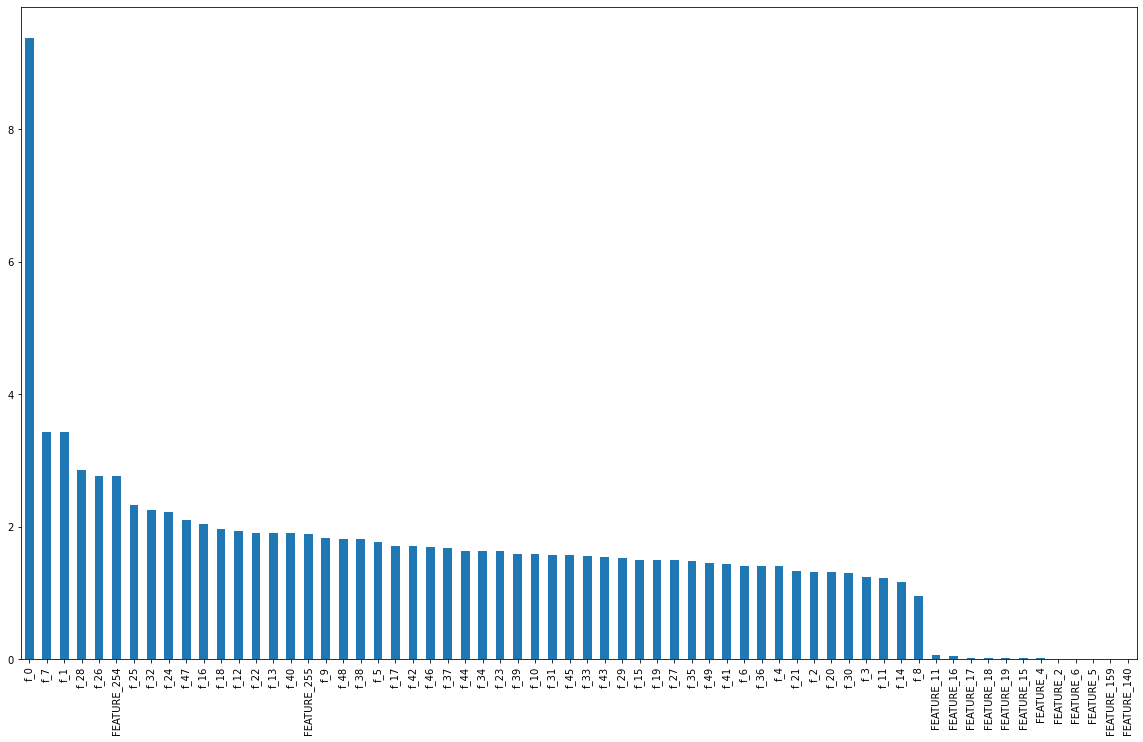

In [ ]:
fi.mean_importance.sort_values(ascending=False).plot.bar(figsize=(20, 12))
plt.show()

In [ ]:
score_all = output["test_score"].mean()

In [ ]:
score_all

0.49244794703935457

In [ ]:
features_imp = fi.mean_importance.sort_values(ascending=False).copy()

In [ ]:
features = list(fi.mean_importance.sort_values(ascending=False).index)

In [ ]:
%%time
# задаем пороговое значение разницы (признак удаляется,
# если улучшение метрики качества модели при добавлении 
# признака меньше, чем данный порог)
tols = [0.0001]
scores = []
feat_to_remove_all = []

for i, tol in enumerate(tols):

  score_all = 0.49244794703935457
  print('выполнение рекурсивного удаления признаков')

  # создаем списки в которые мы будем сохранять результаты 
  # отбора признаков: признаки для удаления, величину
  # метрики качества для текущей итерации, разницу метрик 
  # для модели с переменной и без нее 

  # создаем список, в который будем записывать удаляемые признаки
  feat_to_remove = []
  # создаем список, в который будем записывать значение метрики
  score_int_list = []
  # создаем список, в который будем записывать изменение метрики
  # после удаления переменной
  diff_score_list = []

  # устанавливаем счетчик итераций
  count = 1

  # далее будем в цикле выбирать каждый признак: помним, что
  # features - это список признаков, упорядоченных по важности
  for feature in features:
      print('')
      print(f'проверяемый признак: {feature}, ' 
            f'признак {count} из {len(features)}')
      count = count + 1

      # создаем экземпляр класса CatBoostClassifier
      model_int = CatBoostClassifier(
          iterations=200,
          loss_function='MultiClass',
          random_seed=42,
          random_strength=0.15,
          depth=9,
          learning_rate=0.1,
          auto_class_weights='Balanced',
          logging_level='Silent',
          task_type="GPU"
          )

      # обучаем модели со всеми признаками минус уже удаленные признаки 
      # (берем их из списка удаляемых признаков) и оцениваемый признак
      score_int = cross_val_score(
          model_int,
          new_features.drop(feat_to_remove + [feature], axis=1),
          y_train, 
          scoring='f1_macro', 
          cv=5, fit_params={"cat_features": np.array(categorical_features)[[x in new_features.drop(feat_to_remove + [feature], axis=1) for x in categorical_features]]}).mean()
      
      # печатаем усредненное значение метрики
      print('Новое значение метрики={}'.format((score_int)))
      score_int_list.append(score_int)

      # печатаем метрику модели со всеми признаками
      # (базовое значение метрики)
      string = 'Значение метрики для модели со всеми переменными={}'
      print(string.format(score_all))

      # вычисляем изменение метрики качества
      diff_score = score_all - score_int
      diff_score_list.append(diff_score)

      # сравниваем изменение метрики качества с ранее заданным 
      # нами пороговым значением, если изменение метрики 
      # больше или равно порогу, сохраняем
      if diff_score >= tol: 
          print('Изменение метрики={}'.format(diff_score))
          print('сохраняем: ', feature)
          print('')
          
      # если изменение метрики меньше порога, удаляем
      else:
          print('Изменение метрики={}'.format(diff_score))
          print('удаляем: ', feature)
          print('')
          # если изменение метрики качества меньше, чем 
          # пороговое значение, и мы удаляем признак,
          # нам необходимо установить новое базовое 
          # значение метрики качества, рассчитанной 
          # с учетом удаления признака
          score_all = score_int
          
          # и добавляем удаляемый признак в соответствующий список
          feat_to_remove.append(feature)

  # формируем датафрейм
  df_i = pd.DataFrame({'feature': features, 
                    'score': score_int_list,
                    'diff_score': diff_score_list})        

  # отбор закончен, мы провели оценку всех признаков
  print('ВЫПОЛНЕНО!!')
  print('общее количество признаков для удаления: ', 
        len(feat_to_remove))

  # задаем список признаков, которые мы сохраняем 
  # (т.е. те признаки, которые мы не удалили)
  feat_to_keep = [x for x in features if x not in feat_to_remove]
  print('общее количество признаков для сохранения: ', 
        len(feat_to_keep))
  print(f"score: {score_all}")
  scores.append(score_all)
  feat_to_remove_all.append(feat_to_remove)

  df_i['Keep'] = df_i['feature'].map(lambda x: x in feat_to_keep)
  features_imp = features_imp.reset_index()
  features_imp.rename(columns={'index': 'feature'}, inplace=True)
  df_i = df_i.merge(features_imp, how='left', on=['feature'])
  df_i.sort_values(by='diff_score', ascending=True)

выполнение рекурсивного удаления признаков

проверяемый признак: f_0, признак 1 из 64
Новое значение метрики=0.47921973202448137
Значение метрики для модели со всеми переменными=0.49244794703935457
Изменение метрики=0.013228215014873201
сохраняем:  f_0


проверяемый признак: f_7, признак 2 из 64
Новое значение метрики=0.49534519191940996
Значение метрики для модели со всеми переменными=0.49244794703935457
Изменение метрики=-0.002897244880055383
удаляем:  f_7


проверяемый признак: f_1, признак 3 из 64
Новое значение метрики=0.4904713014410815
Значение метрики для модели со всеми переменными=0.49534519191940996
Изменение метрики=0.00487389047832848
сохраняем:  f_1


проверяемый признак: f_28, признак 4 из 64
Новое значение метрики=0.49099906177956987
Значение метрики для модели со всеми переменными=0.49534519191940996
Изменение метрики=0.0043461301398400876
сохраняем:  f_28


проверяемый признак: f_26, признак 5 из 64
Новое значение метрики=0.48879418152796983
Значение метрики для модел

In [ ]:
 globals()["v" + str(i)] 

In [ ]:
df_i

,feature,score,diff_score,Keep,mean_importance
0,f_0,0.479220,0.013228,True,9.383878e+00
1,f_7,0.495345,-0.002897,False,3.433573e+00
2,f_1,0.490471,0.004874,True,3.422863e+00
3,f_28,0.490999,0.004346,True,2.848237e+00
4,f_26,0.488794,0.006551,True,2.767199e+00
...,...,...,...,...,...
59,FEATURE_2,0.490600,0.005495,True,5.877717e-03
60,FEATURE_6,0.492527,0.003568,True,5.267573e-04
61,FEATURE_5,0.490466,0.005629,True,1.938596e-06
62,FEATURE_159,0.490657,0.005438,True,5.672500e-07


In [ ]:
scores

[0.4960950055872807]

In [ ]:
feat_to_keep = df_i[df_i['Keep'] == True]['feature'].values
feat_to_keep

array(['f_0', 'f_1', 'f_28', 'f_26', 'FEATURE_254', 'f_25', 'f_32',
       'f_24', 'f_47', 'f_16', 'f_18', 'f_12', 'f_22', 'f_13', 'f_40',
       'FEATURE_255', 'f_9', 'f_48', 'f_38', 'f_5', 'f_17', 'f_42',
       'f_46', 'f_37', 'f_44', 'f_34', 'f_23', 'f_39', 'f_10', 'f_31',
       'f_45', 'f_33', 'f_43', 'f_29', 'f_15', 'f_19', 'f_35', 'f_49',
       'f_41', 'f_6', 'f_36', 'f_4', 'f_21', 'f_2', 'f_20', 'f_30', 'f_3',
       'f_11', 'f_14', 'f_8', 'FEATURE_11', 'FEATURE_16', 'FEATURE_17',
       'FEATURE_18', 'FEATURE_19', 'FEATURE_15', 'FEATURE_4', 'FEATURE_2',
       'FEATURE_6', 'FEATURE_5', 'FEATURE_159', 'FEATURE_140'],
      dtype=object)

In [ ]:
#feat_to_keep_asc_true_withcut_true = feat_to_keep.tolist().copy()

In [ ]:
#feat_to_keep_asc_false_withcut_true = feat_to_keep.tolist().copy()

In [ ]:
#feat_to_keep_asc_true_withcut_false_true = feat_to_keep.tolist().copy()

In [ ]:
feat_to_keep_asc_false_withcut_true_false_true = feat_to_keep.tolist().copy()

In [ ]:
categorical_features

Index(['FEATURE_2', 'FEATURE_4', 'FEATURE_5', 'FEATURE_6', 'FEATURE_11',
       'FEATURE_15', 'FEATURE_16', 'FEATURE_17', 'FEATURE_18', 'FEATURE_19',
       'FEATURE_140', 'FEATURE_159', 'FEATURE_254', 'FEATURE_255'],
      dtype='object')

In [ ]:
cat = categorical_features[[x in feat_to_keep_asc_false_withcut_true_false_true for x in categorical_features]].tolist()

In [ ]:
cat

['FEATURE_2',
 'FEATURE_4',
 'FEATURE_11',
 'FEATURE_15',
 'FEATURE_16',
 'FEATURE_17',
 'FEATURE_18',
 'FEATURE_19',
 'FEATURE_140',
 'FEATURE_159',
 'FEATURE_254',
 'FEATURE_255']

In [ ]:
new_features[cat] = new_features[cat].astype("int64")

In [ ]:
new_features = new_features[feat_to_keep_asc_false_withcut_true_false_true]

In [ ]:
cat_test_feat = X_test[categorical_features]
X_test.drop(categorical_features, axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
x_test_for_pca = scaler.transform(X_test)
X_test = pca.transform(x_test_for_pca)
X_test = pd.DataFrame(X_test, columns=["f_" + str(i) for i in range(X_test.shape[1])])
X_test = X_test.merge(cat_test_feat.reset_index(drop=True), how="outer", left_index=True, right_index=True)
X_test[cat] = X_test[cat].astype("int64")
X_test = X_test[feat_to_keep_asc_false_withcut_true_false_true]

In [ ]:
X_test

,f_0,f_1,f_28,f_26,FEATURE_254,f_25,f_32,f_24,f_47,f_16,f_18,f_12,f_22,f_13,f_40,FEATURE_255,f_9,f_48,f_38,f_5,f_17,f_42,f_46,f_37,f_44,f_34,f_23,f_39,f_10,f_31,f_45,f_33,f_43,f_29,f_15,f_19,f_35,f_49,f_41,f_6,f_36,f_4,f_21,f_2,f_20,f_30,f_3,f_11,f_14,f_8,FEATURE_11,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_15,FEATURE_4,FEATURE_2,FEATURE_6,FEATURE_5,FEATURE_159,FEATURE_140
0,2.587884,-4.316798,0.078525,0.492684,1,0.463791,-0.269016,0.489110,0.841165,-0.469903,0.642765,1.678557,-0.085621,0.139803,-0.919383,1,1.653991,0.714706,0.249867,0.186922,-0.387592,0.169370,0.709103,-0.597738,0.186766,-0.176172,0.828969,1.911429,-1.200259,0.112344,0.100308,-0.134079,0.871304,0.128174,0.634469,1.913934,-0.333748,-0.145740,0.497686,-0.302932,0.459606,-3.066348,-1.113968,3.269786,0.531026,0.133775,-3.906606,0.875422,0.624748,0.232739,0,0,0,1,0,1,0,0,0,0,0,0
1,-3.582243,-1.671080,-0.161196,-0.026602,1,-0.511509,0.374932,0.357257,0.177379,0.816444,1.112971,-0.160407,0.101620,0.506366,0.182141,0,-0.091791,-0.114832,0.034464,-0.244969,-1.266210,-0.027463,-0.268718,-0.136430,-0.175230,-0.490762,-0.629458,-0.395647,-1.279297,-0.635089,0.105529,-0.356538,-0.271950,-0.082042,2.401938,-0.664590,0.695420,0.373543,0.707731,0.252737,0.119171,-1.698506,0.706874,-0.714088,0.264497,0.060347,-0.758943,-0.695406,0.501529,-0.066229,0,0,0,0,0,0,0,0,0,0,0,0
2,-8.683116,0.636739,1.937077,0.941053,1,0.314426,-1.211835,0.566868,-0.855115,-0.747898,1.135104,0.029929,-0.340197,-0.639760,-0.341260,0,-3.368576,-1.073329,0.102971,-0.295637,2.301880,-0.214047,-0.152873,-1.244491,-0.044503,0.473665,0.471013,-0.592432,0.635342,1.953996,-0.226315,-0.580369,-0.385373,-0.255144,-0.753411,0.015432,0.046438,-0.533165,-1.587088,1.131894,-0.493982,-0.451489,-0.025760,-1.914898,-0.089064,-1.105349,-2.937585,-0.415352,0.377587,3.443232,0,0,0,0,0,0,0,0,0,0,0,0
3,0.991497,-0.294236,-0.133727,-0.780253,1,1.034831,-0.650191,-1.912169,0.787862,0.925178,-0.794912,-0.739184,-1.727085,0.598862,1.432980,1,1.449802,1.607757,-0.020011,0.022586,2.663388,0.172392,0.215211,-0.670830,1.242258,-0.231328,-1.512057,1.344669,1.118142,0.923723,1.873700,-1.850459,-3.197531,-0.529382,-0.101679,-1.933477,0.114506,0.335108,-0.887473,-2.575558,-0.240581,-1.488110,-2.405732,-0.532339,1.034135,0.208617,2.669573,0.485640,-0.187046,-2.328412,1,0,0,1,0,1,1,0,0,0,0,0
4,-0.295354,3.507480,-2.771222,0.659754,1,-0.557364,-0.331416,-1.111696,0.544674,-0.821918,-2.264617,4.679196,0.075283,0.902056,-0.407424,1,-3.762756,-0.333393,-0.831697,0.138273,-1.075348,0.658107,-0.648134,-1.040239,0.852915,0.622329,2.810146,0.617205,2.008791,0.244857,-0.252798,0.667466,-1.560970,-2.037541,0.891449,-0.934879,-0.224626,0.149490,0.268365,-2.449559,0.482721,-0.215360,-0.647889,-3.797383,-1.073383,1.709424,1.929378,2.246793,0.769815,-3.043172,1,1,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7352,4.419650,-5.742897,-0.567834,-0.444491,0,-0.366551,1.032067,-1.216078,0.597046,1.493041,-1.583106,0.545355,-0.887274,0.602918,0.115995,0,0.837157,0.186889,-0.222277,-0.143446,-1.736149,-0.240066,-0.431562,0.242201,0.118632,-0.591609,0.406454,1.417120,-2.419940,0.218783,0.099012,0.128334,-0.181690,-0.963132,1.102237,-1.400833,0.224541,0.158144,-0.140274,0.252912,0.592236,-0.988102,-0.049443,5.095696,-0.196578,-1.234690,-2.475397,-2.048236,0.007227,1.821477,0,0,0,0,0,0,0,0,0,0,0,0
7353,-4.125844,-0.301962,-1.601297,0.804902,0,0.418310,0.626046,-1.062874,-0.252595,-0.659823,0.648446,0.235496,1.095462,-1.507047,2.111450,0,-0.015371,0.127143,1.853075,0.002588,-0.512190,0.679176,-0.377960,1.341338,0.823758,0.703907,-0.179701,0.651361,0.656554,2.019757,1.855714,-1.174857,-3.344105,1.317946,2.473168,-0.494272,-2.387467,0.535138,-1.175883,-1.208311,0.898126,-0.162558,0.155756,-1.388957,0.310655,-1.042304,0.270103,0.246

In [ ]:
new_features

,f_0,f_1,f_28,f_26,FEATURE_254,f_25,f_32,f_24,f_47,f_16,f_18,f_12,f_22,f_13,f_40,FEATURE_255,f_9,f_48,f_38,f_5,f_17,f_42,f_46,f_37,f_44,f_34,f_23,f_39,f_10,f_31,f_45,f_33,f_43,f_29,f_15,f_19,f_35,f_49,f_41,f_6,f_36,f_4,f_21,f_2,f_20,f_30,f_3,f_11,f_14,f_8,FEATURE_11,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_15,FEATURE_4,FEATURE_2,FEATURE_6,FEATURE_5,FEATURE_159,FEATURE_140
0,6.658151,0.007781,0.046183,-1.205789,0,0.021974,0.766445,0.251898,-0.074449,-3.347430,0.562203,-1.374902,0.935059,-2.508298,1.090576,1,2.196644,-0.276308,-1.643838,-0.451012,1.632495,-0.471415,0.347178,1.650355,0.377137,-0.622234,0.249438,-0.676923,-0.905611,-0.874221,0.271214,2.851130,-0.046946,-3.628784,-0.245275,1.141061,0.600500,1.371527,-0.337644,2.552965,-0.062372,1.267713,-0.305361,1.283845,-0.841447,0.497451,1.587474,-2.598191,-0.777979,-1.215472,0,0,0,0,1,1,0,0,0,0,0,0
1,-2.183447,-2.912016,-0.157251,-0.046550,1,-0.596868,0.401723,0.790533,0.818346,0.107449,0.810042,-1.859013,-0.267389,2.965959,-0.087780,0,-3.494160,-0.468976,0.192276,-0.308893,1.804076,-0.376906,0.237790,-0.079539,0.169128,-0.607267,0.535954,-0.200081,0.981679,-0.298578,0.199315,-0.967933,0.240035,-0.238574,-0.345806,1.154266,0.726001,0.778887,0.767744,1.055508,0.024517,-0.523407,-1.674008,1.040985,1.024192,-0.407767,-3.352616,-0.071390,0.253599,1.534344,0,0,0,0,0,0,0,0,0,0,0,0
2,1.061975,-2.308744,1.071495,-2.437623,1,1.533247,-0.353210,-1.166289,-4.739470,2.945151,-0.237285,-0.638453,-0.522605,0.380938,-1.131321,0,-3.191717,-0.618296,-0.909345,0.209452,0.272991,0.843675,0.711331,-0.447122,0.503902,-0.766427,-1.419242,-0.619190,1.068490,0.702897,-1.652959,-1.445822,4.616787,0.450539,1.233844,-2.722464,-1.246524,3.878694,-0.802209,-2.691309,0.822415,-0.783297,0.880354,1.597423,0.408991,-1.702241,-0.620061,4.096033,0.167209,-1.625077,0,0,0,0,0,0,0,0,1,0,0,0
3,29.035581,-10.259061,-2.680807,-1.127772,0,-6.575287,4.371315,0.624700,5.423810,1.284872,1.602697,-15.347497,9.132274,1.514157,3.278297,1,-3.689216,0.423839,3.482546,1.278286,-2.719220,10.239850,7.665298,-4.016396,1.055765,-3.752684,-8.066393,-3.671804,3.566035,2.570281,-5.624888,1.479896,-3.098778,-4.846752,-13.547644,25.802315,6.682348,-2.673842,-2.203270,-9.095915,-0.347524,3.720705,2.490502,17.643550,-5.620296,-2.056826,-5.825793,-7.347950,-5.486430,-0.554579,0,1,0,0,0,0,0,0,0,0,0,1
4,13.970343,0.696346,-0.707977,-0.139784,1,-2.594506,-0.348928,5.586163,-1.269701,1.262251,5.037613,-1.865022,-1.237329,1.029392,-0.421066,1,1.650293,-1.334314,1.054291,-0.523151,0.465578,-0.030871,0.653403,-0.306902,-1.241558,0.284073,0.253067,0.262534,1.066477,1.279666,-0.353324,-0.624377,0.043010,-1.685798,-0.701511,-3.046254,-0.923410,-0.365892,1.007189,1.549286,0.291097,-2.976537,2.068377,2.250492,0.889628,-0.344630,-4.094000,0.007454,0.527957,1.978432,1,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17159,-3.160613,-1.187251,0.065565,-0.713394,1,-0.201447,0.347945,-0.279098,-0.458615,0.592206,-0.931218,-0.781748,0.655167,-0.992188,-0.276577,0,0.287471,-0.514812,-0.106523,-0.678135,-0.380780,-0.532124,0.072450,-0.183035,-0.301233,0.030604,-0.819677,-0.663237,0.069303,-0.968045,0.016152,-0.894562,0.030711,0.326006,0.270551,0.057419,0.070474,0.196599,0.570068,2.358410,-0.071008,-0.864107,1.166299,-0.656409,-0.775016,0.043402,1.264321,0.603161,-0.329355,0.346223,0,0,0,0,0,0,0,0,0,0,0,0
17160,4.662428,-3.901680,4.907537,2.418160,1,1.635432,-2.392881,-3.118085,-2.008522,1.408101,-1.612050,-0.159868,0.893061,0.827360,0.862033,1,0.586906,-0.516747,3.493569,-0.166840,0.027255,3.920895,-0.133354,-0.890649,-0.302427,-0.952507,-2.646108,-2.759108,-3.271987,-3.218906,2.092129,1.188300,-0.176596,2.116691,-1.606025,-3.049156,1.192443,0.161922,4.859419,-0.617479,-0.509110,0.323487,2.108280,3.812855,-1.651776,2.388361,1.2

In [ ]:
clf_full = CatBoostClassifier(learning_rate=0.015,
                            loss_function='MultiClass',
                            depth=9,
                            iterations=274,
                            random_strength=0.15,
                            random_seed=42,
                            auto_class_weights='Balanced',
                            task_type="GPU"
                            )
# обучаем модель
clf_full.fit(new_features, y_train, eval_set=(X_test, y_test), cat_features=cat, plot=True)
# получаем прогнозы
predictions = clf_full.predict(X_test)

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=True, fitparamscv without cat, pool_cat=None

0.48086190022967035

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=True, fitparamscv without cat, pool_cat=add

0.4831717326070482

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=False, fitparamscv without cat, pool_cat=None

0.48298769575345774

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=False, fitparamscv without cat, pool_cat=add

0.4837577410894666

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=True, fitparamscv with cat, pool_cat=None

0.4798775358572212

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=True, fitparamscv with cat, pool_cat=add

0.48210924148111217

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=False, fitparamscv with cat, pool_cat=None

0.4780246828952464

In [ ]:
f1_score(y_test, predictions, average="macro") # pca + ascending=False, fitparamscv with cat, pool_cat=add

0.4826334960797247

In [ ]:
ctbst = CatBoostClassifier(loss_function='MultiClass',
                           random_strength=0.15,
                           depth=9,
                           auto_class_weights='Balanced',
                           task_type="GPU",
                           random_seed=42,
                           logging_level='Silent')

param_grid = {'l2_leaf_reg': range(0, 32, 4),    
              'learning_rate': [0.01, 0.015, 0.02, 0.05],
              "iterations": range(250, 2001, 250)}

gs = GridSearchCV(ctbst, 
                  param_grid, 
                  cv=5, 
                  scoring='f1_macro',  
                  return_train_score=False)
# выполняем поиск по сетке
gs.fit(train, labels, cat_features=cat)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3cd5f68310>,
             param_grid={'iterations': range(250, 2001, 250),
                         'l2_leaf_reg': range(0, 32, 4),
                         'learning_rate': [0.01, 0.015, 0.02, 0.05]},
             scoring='f1_macro')

In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(
    gs.best_params_))
# смотрим наилучшее значение F1
print("Наилучшее значение F1: {:.3f}".format(
    gs.best_score_))

Наилучшие значения гиперпараметров: {'iterations': 1750, 'l2_leaf_reg': 20, 'learning_rate': 0.02}
Наилучшее значение F1: 0.510


In [ ]:
cv_results = pd.DataFrame(
    gs.cv_results_)[['mean_test_score',
                     'param_l2_leaf_reg',
                     'param_learning_rate',
                     'param_iterations']]
cv_results = cv_results.sort_values(
    by='mean_test_score', ascending=False).reset_index(drop=True)
cv_results

,mean_test_score,param_l2_leaf_reg,param_learning_rate,param_iterations
0,0.509578,20,0.02,1750
1,0.509148,20,0.02,2000
2,0.508962,12,0.015,2000
3,0.508457,12,0.015,1750
4,0.508234,8,0.02,1250
...,...,...,...,...
251,0.394645,0,0.02,1250
252,0.393242,0,0.02,2000
253,0.392461,0,0.02,1500
254,0.389358,0,0.02,1750


In [ ]:
cv_results.head(15)

,mean_test_score,param_l2_leaf_reg,param_learning_rate,param_iterations
0,0.509578,20,0.02,1750
1,0.509148,20,0.02,2000
2,0.508962,12,0.015,2000
3,0.508457,12,0.015,1750
4,0.508234,8,0.02,1250
5,0.507487,4,0.01,2000
6,0.507468,8,0.02,1500
7,0.507446,28,0.02,2000
8,0.507367,12,0.02,1500
9,0.507309,24,0.015,2000


In [ ]:
#feat_to_keep_asc_true_withcut_false_true
ctbst2 = CatBoostClassifier(loss_function='MultiClass',
                           random_strength=0.15,
                           depth=9,
                           auto_class_weights='Balanced',
                           task_type="GPU",
                           random_seed=42,
                           logging_level='Silent')

param_grid2 = {'l2_leaf_reg': range(15, 22, 2),    
              'learning_rate': [0.015, 0.02],
              "iterations": range(1500, 2001, 250)}

gs2 = GridSearchCV(ctbst2, 
                  param_grid2, 
                  cv=5, 
                  scoring='f1_macro',  
                  return_train_score=False)
# выполняем поиск по сетке
gs2.fit(train, labels, cat_features=cat)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3cd5e3b350>,
             param_grid={'iterations': range(1500, 2001, 250),
                         'l2_leaf_reg': range(15, 22, 2),
                         'learning_rate': [0.015, 0.02]},
             scoring='f1_macro')

In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(
    gs2.best_params_))
# смотрим наилучшее значение F1
print("Наилучшее значение F1: {:.3f}".format(
    gs2.best_score_))

Наилучшие значения гиперпараметров: {'iterations': 2000, 'l2_leaf_reg': 17, 'learning_rate': 0.015}
Наилучшее значение F1: 0.506


In [ ]:
cv_results2 = pd.DataFrame(
    gs2.cv_results_)[['mean_test_score',
                     'param_l2_leaf_reg',
                     'param_learning_rate',
                     'param_iterations']]
cv_results2 = cv_results2.sort_values(
    by='mean_test_score', ascending=False).reset_index(drop=True)
cv_results2

In [ ]:
cv_results.head(15)

,mean_test_score,param_l2_leaf_reg,param_learning_rate,param_iterations
0,0.509578,20,0.02,1750
1,0.509148,20,0.02,2000
2,0.508962,12,0.015,2000
3,0.508457,12,0.015,1750
4,0.508234,8,0.02,1250
5,0.507487,4,0.01,2000
6,0.507468,8,0.02,1500
7,0.507446,28,0.02,2000
8,0.507367,12,0.02,1500
9,0.507309,24,0.015,2000


In [ ]:
cv_results2.head(15)

,mean_test_score,param_l2_leaf_reg,param_learning_rate,param_iterations
0,0.506480,17,0.015,2000
1,0.506284,19,0.015,1750
2,0.505565,19,0.02,1750
3,0.505151,15,0.015,2000
4,0.505068,17,0.015,1750
5,0.504962,19,0.015,2000
6,0.504910,15,0.02,1750
7,0.504787,17,0.02,1750
8,0.504636,19,0.02,2000
9,0.504483,15,0.02,1500


#Итог

In [ ]:
train = pd.read_csv("/content/contest_train.csv")
test = pd.read_csv("/content/contest_test.csv")

test_id = test["ID"]
train.drop("ID", axis=1, inplace=True)
test.drop("ID", axis=1, inplace=True)
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)
labels = train.pop("TARGET")
constant_features = [feature for feature in train.columns if train[feature].nunique() == 1]
train.drop(labels=constant_features, axis=1, inplace=True)
test.drop(labels=constant_features, axis=1, inplace=True)
categorical_features = (train.nunique()[train.nunique()==2]).index
categorical_features_train = train[categorical_features]
categorical_features_test = test[categorical_features]
train.drop(categorical_features, axis=1, inplace=True)
test.drop(categorical_features, axis=1, inplace=True)
scaler = StandardScaler()
scaler.fit(train)
train_for_pca = scaler.transform(train)
test_for_pca = scaler.transform(test)
pca =  PCA(61, random_state=42).fit(train_for_pca)
train = pca.transform(train_for_pca)
test = pca.transform(test_for_pca)
train = pd.DataFrame(train, columns=["f_" + str(i) for i in range(train.shape[1])])
test = pd.DataFrame(test, columns=["f_" + str(i) for i in range(test.shape[1])])
train = train.merge(categorical_features_train, how="outer", left_index=True, right_index=True)
test = test.merge(categorical_features_test, how="outer", left_index=True, right_index=True)

cat = categorical_features[[x in feat_to_keep_asc_false_withcut_true_false_true for x in categorical_features]].tolist()
train = train[feat_to_keep_asc_false_withcut_true_false_true]
train[cat] = train[cat].astype("int64")
test = test[feat_to_keep_asc_false_withcut_true_false_true]
test[cat] = test[cat].astype("int64")

clf_full = CatBoostClassifier(
    learning_rate=0.02,
    loss_function='MultiClass',
    depth=9,
    iterations=2000,
    l2_leaf_reg=20,
    random_strength=0.15,
    random_seed=42,
    auto_class_weights='Balanced',
    logging_level='Silent',
    task_type="GPU"
    )

clf_full.fit(train, labels, cat_features=cat)
predictions = clf_full.predict(test)

pd.DataFrame({'ID': test_id, 
              'Predicted': predictions.reshape(-1)}).to_csv(
    'feat_to_keep_asc_false_withcut_true_false_true_3_pca_61.csv', index=False)